# **Extracting Topic model by  "Latent Dirichlet Allocation (LDA)"  of kepler's book: "Astronomia Nova** "
<font size="4">
This notebook demonstrates how to **extract topics **  from documents, corpus, book. We visualize the result in an informative way. Here, an unsupervised learning model LDA is used. **Topic modelling** is based on the basic assumptions that each corpus (book)  consists of different topics and each topic consists of a collection of words.
<font/>


### Import the required tools 

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import collections
import os
import logging
import warnings
from itertools import permutations
from sklearn.metrics import make_scorer,confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import sklearn_crfsuite  # to install this package in windows with pip please run: 'pip install sklearn-crfsuite'
from sklearn_crfsuite import metrics, scorers
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import eli5  # to install this package in windows with conda please run: 'conda install -c conda-forge eli5'
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from gensim import corpora, models  # to install this package in windows with conda please run: 'models conda install -c conda-forge gensim'
nltk.download('wordnet')
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\moha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\moha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Please download the data '01_df_v013.pickle' in github on  your local machine from  this directory: vorlesung2019/notebooks/yeghaneh/data

In [2]:
importVersion = '013'  # The  desired version pickle-file of your data (now we are working on version 013 of our data)

In [3]:
path = '../data/01_df_v{0}.pickle'.format(importVersion)  # Put the path of the data in your local machine here, consider the letter "r" before the path

### Let's use data "01_df_v013" to build a NER system. 
<font size="3">The data 01_df_v013 is annotated (labeled) data of english version of well-known kepler's book: New Astronomy (Latin: Astronomia nova). You can find that in the repository.
             </font>


## **Read the data** 
<font size="3">The data  is saves as a pickle file. We read it as a pandas dataFrame. </font>

In [67]:
dfAstroNova = pd.read_pickle(path)  # Put the path of the data in your local machine here, consider the letter "r" before the path

<font size="4"> Sort the data based on the chapters of the book 
</font>

In [68]:
dfAstroNova['chapter'] = dfAstroNova.chapter.replace("appendix b",np.nan).astype(float)  
dfAstroNova.sort_values(by='chapter' , inplace=True)
dfAstroNova.chapter.fillna('appendix b', inplace=True)

In [69]:
len(dfAstroNova)   # Number of rows.

1605

In [70]:
dfAstroNova.head(5)  

,html,text,links,italic,chapter,graphic,table,marginal,sentences,tagged
18,"<p><span class=""anchor"" id=""bookmark0""></span>...",Chapter 1,[],[],1,[],[],[],[Chapter 1],"[[(Chapter, None), (1, NUM)]]"
34,"<p>But before that, I shall prove in this firs...","But before that, I shall prove in this first p...",[],[],1,[],[],[],"[But before that, I shall prove in this first ...","[[(But, None), (before, None), (that, None), (..."
33,<p>But since the sun's mean and apparent motio...,But since the sun's mean and apparent motions*...,[],"[Mysterium cosmographicum,]",1,[],[],[ Terms: * The sun's apparent position is that...,[But since the sun's mean and apparent motions...,"[[(But, None), (since, None), (the, None), (su..."
32,<p>Now the causes and measures of these inequa...,Now the causes and measures of these inequalit...,[],[],1,[],[],[ 5],[Now the causes and measures of these inequali...,"[[(Now, None), (the, None), (causes, None), (a..."
30,"<p>Again, however, it was noticed that these l...","Again, however, it was noticed that these loop...",[],[],1,[],[],[],"[Again, however, it was noticed that these loo...","[[(Again, None), (however, None), (it, None), ..."


In [71]:
dfAstroNova[740:745]

,html,text,links,italic,chapter,graphic,table,marginal,sentences,tagged
594,"<p><span class=""anchor"" id=""bookmark1""></span>...","Whether the motion from the sun, like its ligh...",[{'#fn1': 'άντίφραχις.↩'}],[],35,[],[],[],"[Whether the motion from the sun, like its lig...","[[(Whether, None), (the, None), (motion, None)..."
596,"<p>And concerning the first, it is worthy of c...","And concerning the first, it is worthy of cons...",[],[],35,[],[],[],"[And concerning the first, it is worthy of con...","[[(And, None), (concerning, None), (the, None)..."
595,<p>This is a good time for me to take up the o...,This is a good time for me to take up the obje...,[],[species],35,[],[],[],[This is a good time for me to take up the obj...,"[[(This, None), (is, None), (a, None), (good, ..."
598,"<p>But it is answered, first, that the analogy...","But it is answered, first, that the analogy be...",[],[],35,[],[],[],"[But it is answered, first, that the analogy b...","[[(But, None), (it, None), (is, None), (answer..."
599,<p>On this account I would nearly separate lig...,On this account I would nearly separate light ...,[],[],35,[],[],[],[On this account I would nearly separate light...,"[[(On, None), (this, None), (account, None), (..."


In [72]:
dfAstroNova[1585:1590]

,html,text,links,italic,chapter,graphic,table,marginal,sentences,tagged
1568,<p>{marginal: The words of the observation hav...,Consider whether the meaning could be this: t...,[],[],70,[],[],[ The words of the observation have their comm...,[Consider whether the meaning could be this: t...,"[[(Consider, None), (whether, None), (the, Non..."
1569,<p>This interpretation is furthered by the obs...,This interpretation is furthered by the observ...,[],[],70,[],[],[],[This interpretation is furthered by the obser...,"[[(This, None), (interpretation, None), (is, N..."
0,<p>Appendix B</p>,Appendix B,[],[],appendix b,[],[],[],[Appendix B],"[[(Appendix, None), (B, None)]]"
1,"<p><span class=""anchor"" id=""bookmark0""></span>...",On the Table of Oppositions in Chapter 15,[],[],appendix b,[],[],[],[On the Table of Oppositions in Chapter 15],"[[(On, None), (the, None), (Table, None), (of,..."
2,"<p>by Yaakov Zik <span style=""font-variant: sm...",by Yaakov Zik Table i:,[],[],appendix b,[],[],[],[by Yaakov Zik Table i:],"[[(by, None), (Yaakov, None), (Zik, None), (Ta..."


In [73]:
dfAstroNova.tail(5)

,html,text,links,italic,chapter,graphic,table,marginal,sentences,tagged
13,<p>{table: appendix B t 2}</p>,,[],[],appendix b,[],[ appendix B t 2],[],[],[]
14,"<p>Kepler's table, for comparison {table: appe...","Kepler's table, for comparison",[],[],appendix b,[],[ appendix B t 3],[],"[Kepler's table, for comparison]","[[(Kepler, None), (s, None), (table, None), (f..."
15,<p>Mars from Earth to be a little greater than...,Mars from Earth to be a little greater than ha...,[{'#fn6': ' Kepler's observations yield topoce...,[],appendix b,[],[],[],[Mars from Earth to be a little greater than h...,"[[(Mars, None), (from, None), (Earth, None), (..."
16,"<p><img height=""300"" src=""media/image1.jpeg"" w...","As shown in Figure 2B, the Sun is assumed to ...",[],[],appendix b,[ appendix b gr 1],[],[],"[As shown in Figure 2B, the Sun is assumed to ...","[[(As, None), (shown, None), (in, None), (Figu..."
17,<p>The Sun moved westward and its longitude de...,The Sun moved westward and its longitude decre...,[],[4<sup>h</sup> 23<sup>m </sup>],appendix b,[],[],[],[The Sun moved westward and its longitude decr...,"[[(The, None), (Sun, None), (moved, None), (we..."


## **Primary Data Exploration**

In [74]:
dfAstroNova["text"][5]    # 5th row of the data in the format of text 

"The time is measured from midnight; Gregorian dates are obtained by adding 10 days to Kepler's dates. The dates are given in old style."

In [75]:
dfAstroNova["tagged"][5] # 5th row of the data in a format (token, label). A list of lists of tuples! later position tags of the token will be added to each tuple. the tokens are chosen before by some rules.

[[('The', 'None'),
  ('time', 'None'),
  ('is', 'None'),
  ('measured', 'None'),
  ('from', 'None'),
  ('midnight', 'None'),
  ('Gregorian', 'None'),
  ('dates', 'None'),
  ('are', 'None'),
  ('obtained', 'None'),
  ('by', 'None'),
  ('adding', 'None'),
  ('10', 'NUM'),
  ('days', 'None'),
  ('to', 'None'),
  ('Kepler', 'None'),
  ('s', 'None'),
  ('dates', 'None')],
 [('The', 'None'),
  ('dates', 'None'),
  ('are', 'None'),
  ('given', 'None'),
  ('in', 'None'),
  ('old', 'None'),
  ('style', 'None')]]

In [76]:
df=dfAstroNova["tagged"]

In [77]:
df[0:3]

18                        [[(Chapter, None), (1, NUM)]]
34    [[(But, None), (before, None), (that, None), (...
33    [[(But, None), (since, None), (the, None), (su...
Name: tagged, dtype: object

In [78]:
df = sum(df, [])  # Flatt the data by removing first lists
len(df)

6699

In [79]:
df[5]  

[('Copernicus', 'None'),
 ('and', 'None'),
 ('Tycho', 'None'),
 ('followed', 'None'),
 ('Ptolemy', 'None'),
 ('carrying', 'None'),
 ('over', 'None'),
 ('his', 'None'),
 ('assumptions', 'None')]

In [80]:
df_flatten = sum(df,[])  # Flatt the data by removing the second list


In [81]:
df_flatten[0:20]  # Here we have tokens (entities) with their labels

[('Chapter', 'None'),
 ('1', 'NUM'),
 ('But', 'None'),
 ('before', 'None'),
 ('that', 'None'),
 ('I', 'None'),
 ('shall', 'None'),
 ('prove', 'None'),
 ('in', 'None'),
 ('this', 'None'),
 ('first', 'None'),
 ('part', 'None'),
 ('that', 'None'),
 ('one', 'None'),
 ('who', 'None'),
 ('substitutes', 'None'),
 ('the', 'None'),
 ('sun', 'None'),
 ('s', 'None'),
 ('apparent', 'None')]

In [82]:
len(df_flatten)  # Number of all tokens (roughly speaking all words or entities)

169231

In [83]:

tokens = [x[0] for x in df_flatten]  # Extract the tokens for further use in the frequency plot

In [84]:
labels=([x[1] for x in df_flatten])  # Extract the labels for further use in the frequency plot

In [85]:
tokens[0:5]

['Chapter', '1', 'But', 'before', 'that']

In [86]:
labels[0:5]

['None', 'NUM', 'None', 'None', 'None']

## **Visualization**

### Frequency plot of all words in all chapter of book

<font size="3">
Frequency plot of all tokens in text, as you see there is a lot 'the', 'of',... in text, they normally consider as noise, we will back to that later.
<font/>

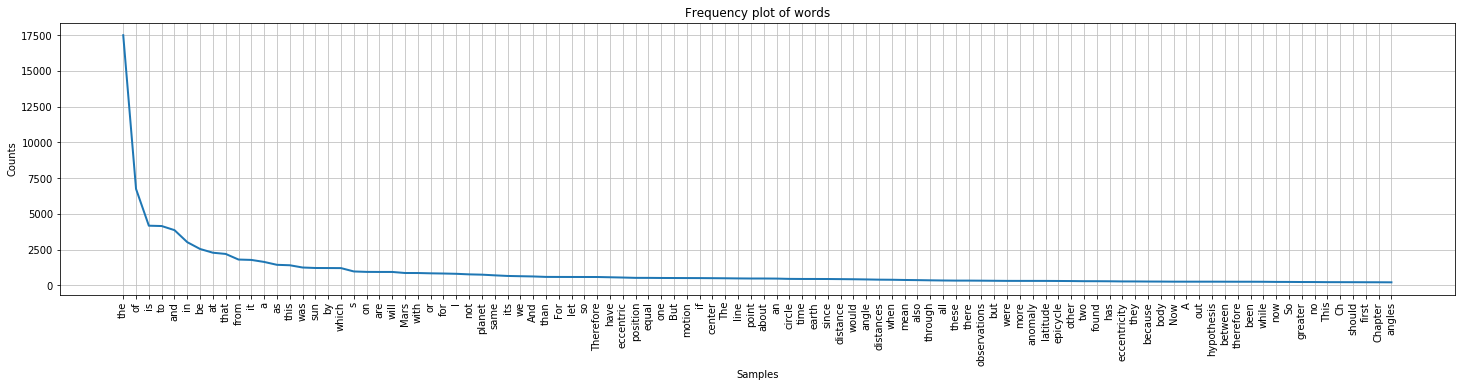

In [87]:
freqdist = nltk.FreqDist(tokens)
plt.figure(figsize=(25,5))
freqdist.plot(100, title='Frequency plot of words')


In [89]:
stop_words=["therfore","would","but","also", "let", "would", "the", "of", "is", "to", "and","in", "be", "at", "that", "from", "it", "a", "as","this", "was" ] # we can consider these as stop words or we can use nltk stop words.

In [133]:
# nltk stop words
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))
stop_words=stop_words.union(["Therefore","But", "would","but","also", "let",'I', 'And', 'For', 'A', 'The'])
#stop_words_nltk = set(stop_words)

# List of nltk stop words {‘ourselves’, ‘hers’, ‘between’, ‘yourself’, ‘but’, ‘again’, ‘there’, ‘about’, ‘once’, ‘during’, ‘out’, ‘very’, ‘having’, ‘with’, ‘they’, ‘own’, ‘an’, ‘be’, ‘some’, ‘for’, ‘do’, ‘its’, ‘yours’, ‘such’, ‘into’, ‘of’, ‘most’, ‘itself’, ‘other’, ‘off’, ‘is’, ‘s’, ‘am’, ‘or’, ‘who’, ‘as’, ‘from’, ‘him’, ‘each’, ‘the’, ‘themselves’, ‘until’, ‘below’, ‘are’, ‘we’, ‘these’, ‘your’, ‘his’, ‘through’, ‘don’, ‘nor’, ‘me’, ‘were’, ‘her’, ‘more’, ‘himself’, ‘this’, ‘down’, ‘should’, ‘our’, ‘their’, ‘while’, ‘above’, ‘both’, ‘up’, ‘to’, ‘ours’, ‘had’, ‘she’, ‘all’, ‘no’, ‘when’, ‘at’, ‘any’, ‘before’, ‘them’, ‘same’, ‘and’, ‘been’, ‘have’, ‘in’, ‘will’, ‘on’, ‘does’, ‘yourselves’, ‘then’, ‘that’, ‘because’, ‘what’, ‘over’, ‘why’, ‘so’, ‘can’, ‘did’, ‘not’, ‘now’, ‘under’, ‘he’, ‘you’, ‘herself’, ‘has’, ‘just’, ‘where’, ‘too’, ‘only’, ‘myself’, ‘which’, ‘those’, ‘i’, ‘after’, ‘few’, ‘whom’, ‘t’, ‘being’, ‘if’, ‘theirs’, ‘my’, ‘against’, ‘a’, ‘by’, ‘doing’, ‘it’, ‘how’, ‘further’, ‘was’, ‘here’, ‘than’} 


<font size="3">
We can consider these words like 'the', 'of',... as noises. so we temporary remove those! 
<font/>

In [134]:

new_tokens = []     
for w in tokens:
    if w not in stop_words: new_tokens.append(w)      

### Frequency plot of all words in all chapter of book after removing the stop words

<font size="3">
It shows word "sun" is most common word.  We can also see the word Mars, planet, eccentric as common words in the book 
<font/>

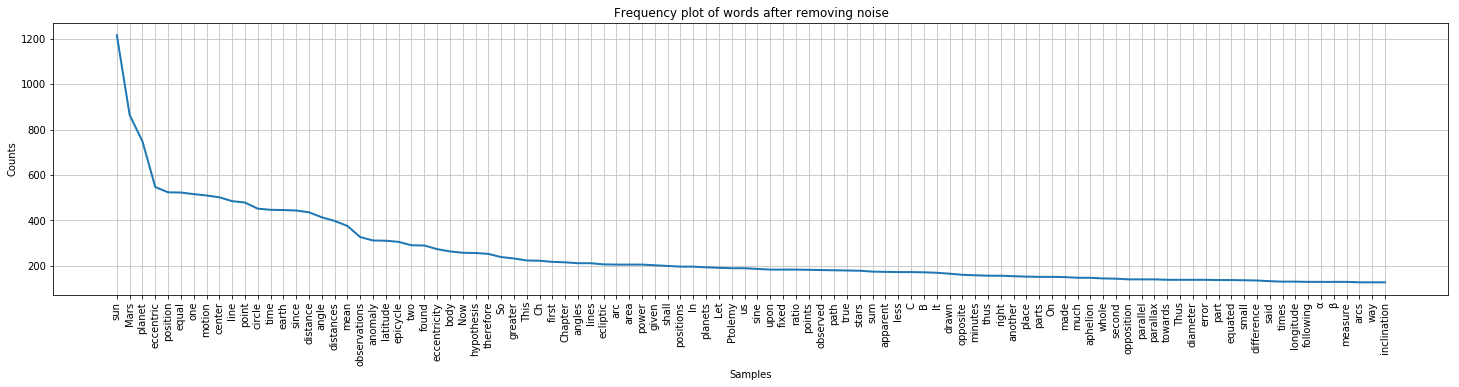

In [135]:
freqdist = nltk.FreqDist(new_tokens) 
plt.figure(figsize=(25,5)) 
freqdist.plot(100, title='Frequency plot of words after removing noise')

<font size="4">
Do we need more insight than frequency plot of word for see content of the book? the question is answered by the follwoing cells through investigation of "topic modelling"
<font/>

## **Topic Modelling by LDA**

 Here you see an structured workflow to build an insightful "topic model" based on the Latent Dirichlet Allocation (LDA) algorithm,  modeled as Dirichlet distributions Dir(α).
 For more detail you can read: <p>
http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf
    </p>

### **Pre-processing**

<font size="3">
Since we alreay tokenized the text (split text into  word without punctuation) and removed stopwrods, we only need to **lemmatize** and **stemm** the tokens.
<font/>

In [136]:
mytext = nltk.Text(new_tokens) 

#### Lemmatization 

<font size="3">
Lemmatization, takes into consideration the morphological analysis of the words. For instance  "do", "does", "did" and "doing" are forms of the same lexeme with "do" as the lemma. Another example would be  "car", "cars", "automobile"
<font/>

In [137]:
#lemmatization
w_lemmatize= WordNetLemmatizer()
my_text_lemmatize = [w_lemmatize.lemmatize(word) for word in mytext]


#### Stemming

<font size="3">
Stemming algorithms work by cutting off the end or the beginning of the word, by taking into account a list of common prefixes and suffixes. It reduces words to their word stem or root form. For instance, stemming for root word "like" include:"likes", "liked", "likely", "liking
<font size=/>

# stemming 
p_stemmers=PorterStemmer()  
my_text_lemm_stemmer = [p_stemmers.stem(word) for word in my_text_lemmatize]

my_text_lemm_stemmer=[my_text_lemm_stemmer] #make a list of list

In [138]:
my_text_lemmatize=[my_text_lemmatize]

#### Select a document to preview after preprocessing.

In [139]:
Dic=corpora.Dictionary(my_text_lemmatize)

### **Bag of Words on the Data set**

<font size="4">
Our dictionary must be converted to "bag of word". Frequency of occurrence of each word is used as a feature for training a classifier. It means it should contain the number of times a word appears
<font size>

In [140]:
corpus = [Dic.doc2bow(text) for text in my_text_lemmatize]

#### Running LDA using Bag of Words**

In [173]:
ldamodel =models.ldamodel.LdaModel(corpus, num_topics=3,  id2word = Dic, passes=3, iterations=10)

In [174]:
lda_topics=ldamodel.print_topics()

In [175]:
lda_topics

[(0,
  '0.013*"sun" + 0.012*"Mars" + 0.009*"distance" + 0.009*"planet" + 0.008*"point" + 0.008*"line" + 0.007*"eccentric" + 0.007*"motion" + 0.007*"position" + 0.007*"angle"'),
 (1,
  '0.015*"sun" + 0.010*"position" + 0.009*"line" + 0.009*"planet" + 0.009*"distance" + 0.008*"time" + 0.008*"Mars" + 0.008*"motion" + 0.007*"equal" + 0.007*"center"'),
 (2,
  '0.013*"sun" + 0.012*"planet" + 0.009*"Mars" + 0.009*"distance" + 0.008*"angle" + 0.008*"position" + 0.007*"one" + 0.007*"point" + 0.007*"line" + 0.006*"motion"')]

In [176]:
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, Dic)

# 3 Topics

In [177]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.003989  0.000237       1        1  47.408207
1      0.001755 -0.003074       2        1  26.856476
0      0.002234  0.002837       3        1  25.735315, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
7578  Default  1093.000000          sun  1093.000000  30.0000  30.0000
6000  Default   624.000000         line   624.000000  29.0000  29.0000
3192  Default   780.000000         Mars   780.000000  28.0000  28.0000
6605  Default   650.000000     position   650.000000  27.0000  27.0000
6192  Default   551.000000       motion   551.000000  26.0000  26.0000
5077  Default   476.000000        equal   476.000000  25.0000  25.0000
4120  Default   276.000000         body   276.000000  24.0000  24.0000
7732  Default   520.000000         time   520.000000  23.0000  23.0000
4950  Default   515.000000    eccentric   515.000000  22.0000  22.0000
4872  Default   753.000000     distance   753.000000  21.0000  21.0000
7862  Default   260.000000          two   260.000000  20.0000  20.0000
6591  Default   597.000000        point   597.000000  19.0000  19.0000
6103  Default   371.000000         mean   371.000000  18.0000  18.0000
4221  Default   481.000000       center   481.000000  17.0000  17.0000
7317  Default   224.000000         sine   224.000000  16.0000  16.0000
3843  Default   300.000000      anomaly   300.000000  15.0000  15.0000
6628  Default   202.000000        power   202.000000  14.0000  14.0000
6323  Default   406.000000  observation   406.000000  13.0000  13.0000
7947  Default   164.000000         upon   164.000000  12.0000  12.0000
3148  Default   172.000000          Let   172.000000  11.0000  11.0000
3902  Default   301.000000          arc   301.000000  10.0000  10.0000
4258  Default   460.000000       circle   460.000000   9.0000   9.0000
4940  Default   404.000000        earth   404.000000   8.0000   8.0000
2515  Default   155.000000            C   155.000000   7.0000   7.0000
6470  Default   136.000000     parallel   136.000000   6.0000   6.0000
5069  Default   292.000000     epicycle   292.000000   5.0000   5.0000
7839  Default   162.000000         true   162.000000   4.0000   4.0000
6267  Default   134.000000         node   134.000000   3.0000   3.0000
6389  Default   141.000000   opposition   141.000000   2.0000   2.0000
7291  Default   122.000000         side   122.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
6389   Topic3    43.887482   opposition   141.894974   0.1838  -6.1709
7721   Topic3    28.963411        three    91.269325   0.2095  -6.5865
3525   Topic3    38.863140         Thus   125.455841   0.1854  -6.2925
6591   Topic3   164.354553        point   597.964966   0.0658  -4.8505
6852   Topic3    54.024181        ratio   179.106628   0.1588  -5.9631
6628   Topic3    60.423092        power   202.342361   0.1487  -5.8512
3902   Topic3    86.051620          arc   301.369690   0.1039  -5.4976
4872   Topic3   198.020401     distance   753.765320   0.0206  -4.6642
5948   Topic3    47.284355           le   156.504486   0.1604  -6.0964
7578   Topic3   274.742279          sun  1093.683472  -0.0242  -4.3367
6192   Topic3   148.107666       motion   551.852173   0.0420  -4.9546
5069   Topic3    83.088310     epicycle   292.349396   0.0993  -5.5326
3843   Topic3    84.363525      anomaly   300.479126   0.0871  -5.5174
6000   Topic3   160.342987         line   624.761841  -0.0027  -4.8752
5327   Topic3    49.732895        fixed   165.890594   0.1526  -6.0459
4258   Topic3   115.231026       circle   460.264221  -0.0276  -5.2056
3833   Topic3   136.568161        angle   570.112854  -0.0717  -5.0357
6323   Topic3   102.093132  observation   406.814575  -0.0252  -5.3267
6576   Topic3   180.532639       planet   862.269470  -0.2064  -4.

# 7 Topics

In [171]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.003612 -0.002136       1        1  62.267845
1      0.002924  0.003568       2        1  13.602233
2      0.002405 -0.002495       3        1   8.739380
4     -0.000049  0.000668       4        1   5.743853
6     -0.001848 -0.001223       5        1   4.757052
0     -0.000916  0.002105       6        1   4.051950
3     -0.006129 -0.000487       7        1   0.837693, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
7578  Default  1157.000000           sun  1157.000000  30.0000  30.0000
6576  Default   804.000000        planet   804.000000  29.0000  29.0000
3192  Default   783.000000          Mars   783.000000  28.0000  28.0000
4872  Default   728.000000      distance   728.000000  27.0000  27.0000
6605  Default   687.000000      position   687.000000  26.0000  26.0000
6591  Default   600.000000         point   600.000000  25.0000  25.0000
6000  Default   649.000000          line   649.000000  24.0000  24.0000
6192  Default   501.000000        motion   501.000000  23.0000  23.0000
3833  Default   564.000000         angle   564.000000  22.0000  22.0000
4950  Default   558.000000     eccentric   558.000000  21.0000  21.0000
7732  Default   548.000000          time   548.000000  20.0000  20.0000
4221  Default   469.000000        center   469.000000  19.0000  19.0000
5077  Default   476.000000         equal   476.000000  18.0000  18.0000
6371  Default   532.000000           one   532.000000  17.0000  17.0000
7316  Default   409.000000         since   409.000000  16.0000  16.0000
4940  Default   391.000000         earth   391.000000  15.0000  15.0000
4258  Default   485.000000        circle   485.000000  14.0000  14.0000
6323  Default   415.000000   observation   415.000000  13.0000  13.0000
6103  Default   384.000000          mean   384.000000  12.0000  12.0000
5936  Default   335.000000      latitude   335.000000  11.0000  11.0000
5069  Default   295.000000      epicycle   295.000000  10.0000  10.0000
4951  Default   245.000000  eccentricity   245.000000   9.0000   9.0000
3843  Default   298.000000       anomaly   298.000000   8.0000   8.0000
3902  Default   303.000000           arc   303.000000   7.0000   7.0000
4120  Default   289.000000          body   289.000000   6.0000   6.0000
5608  Default   269.000000    hypothesis   269.000000   5.0000   5.0000
6473  Default   244.000000          part   244.000000   4.0000   4.0000
7862  Default   274.000000           two   274.000000   3.0000   3.0000
7450  Default   234.000000          star   234.000000   2.0000   2.0000
5382  Default   267.000000         found   267.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
4872   Topic7     5.719154      distance   728.397278  -0.0648  -4.7837
2530   Topic7     0.283305           CBD    22.131645   0.4240  -7.7888
6399   Topic7     1.614744           orb   167.573929   0.1400  -6.0484
4221   Topic7     3.909775        center   469.532562  -0.0060  -5.1641
7572   Topic7     1.603566           sum   168.197723   0.1294  -6.0553
2591   Topic7     1.869452            Ch   201.487564   0.1022  -5.9019
7050   Topic7     0.805642       respect    75.061729   0.2478  -6.7437
2751   Topic7     0.874138             E    82.973351   0.2292  -6.6621
7634   Topic7     0.865619         table    83.261703   0.2160  -6.6719
3847   Topic7     1.298680       another   135.505188   0.1346  -6.2662
2445   Topic7     1.461351             B   157.214233   0.1040  -6.1482
5069   Topic7     2.465998      epicycle   295.428253  -0.0036  -5.6250
3468   Topic7     1.862650            So   212.157242   0.0469  -5.9056
4950   Topic7     4.076998     eccentric   558.933960  -0.1384  -5.1222
3044   Topic7     1.341364            It   142.453018   0.1169  -6.2339
6000   Topic7  

In [172]:
pyLDAvis.save_html(vis,'vis_07_topics_all_chapters.html') # You can open saved html file  (vis_01)in your browser to see the result. 

<font size= "4">
How can we find that how many topics are proper for a model?
<font/>

## **Coherence Metric**